In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1067b51e-a4c2-105d-89a8-cce898d258e6)


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-23 14:55:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-23 14:55:53 (68.3 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get the dataset

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-05-23 14:55:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.2’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-05-23 14:55:54 (109 MB/s) - ‘nlp_getting_started.zip.2’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:

`sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
`train.csv` - training samples of real and not real diaster Tweets.
`test.csv` - testing samples of real and not real diaster Tweets.


## Visualizing a text dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


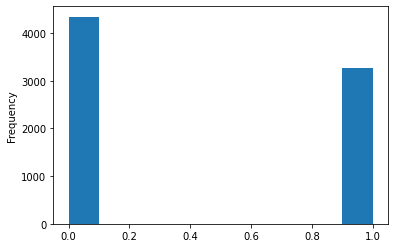

In [ ]:
train_df.target.plot.hist()

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [ ]:
# visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-6) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+6].itertuples():
  _, text, target = row # _ to get rid of index
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Why did God order obliteration of ancient Canaanites? http://t.co/Sf2vwQvJYa

---

Target: 0 (not real disaster)
Text:
Finnish ministers: Fennovoima nuclear reactor will go ahead http://t.co/mqMCOLwBzc

---

Target: 1 (real disaster)
Text:
'It looks like a mudslide' poor thing! ?? #greatbritishbakeoff

---

Target: 1 (real disaster)
Text:
Criminals Who Hijack Lorries And Buses Arrested In Enugu (PHOTO) @DONJAZZY @PoliceNG #HumanRights  https://t.co/XyFl8wy62g

---

Target: 1 (real disaster)
Text:
The Catastrophic Effects of Hiroshima and Nagasaki Atomic Bombings Still Being Felt Today http://t.co/oU1M9chznq

---

Target: 1 (real disaster)
Text:
ÛÏ@FDNY: This morning #FDNY responded to a sinkhole in #Brooklyn. Units remain on-scene with @NYCBuildings &amp; others. http://t.co/M78ir0IK01Û

---



## Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, 
                                                                            random_state=42) 


In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

### Converting text into numbers
When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
- Tokenziation- direct mapping of token (a token could be a word or a character) to number
- Embedding- create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be
learned)

### Text vectorization (tokenization)

The `TextVectorization` layer takes the following parameters:

- `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
- `standardize` - Method for standardizing text. Default is "`lower_and_strip_punctuation`" which lowers text and removes all punctuation marks.
- `split` - How to split text, default is "`whitespace`" which splits on spaces.
- `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
- `output_mode` - How to output tokens, can be "`int`" (integer mapping), "`binary`" (one-hot encoding), "`count`" or "`tf-idf`". 
- `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
- `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes.

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf

# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.TextVectorization(
                                    max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
train_sentences[0], len(train_sentences[0].split())

('@mogacola @zamtriossu i screamed after hitting tweet', 7)

In [ ]:
# find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    output_mode="int",
                                                    output_sequence_length=max_length)

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.



In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length`=15, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@KushWush I'm still traumatised by your driving. Having flashbacks of the lane hogging ?? 

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,   32,   80,  412,   18,   33, 1027,  652, 5631,    6,    2,
        2069,    1,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

Embedding is respresentation of relationship between tokens to be more learnable for model

The main parameters we're concerned about here are:

- `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
- `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a feature vector of size 100 for each word.
- `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
- `input_length` - Length of sequences being passed to embedding layer.


In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\\n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Rainstorm downtown Gloucester
#gloucester #capeann #seagulls #triciaoneill #triciaoneillphoto https://t.co/oLS6qdi9Um\n
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00855206,  0.0226786 , -0.04425555, ..., -0.03941157,
         -0.03334795,  0.0304966 ],
        [-0.04383419, -0.04763404,  0.0451599 , ..., -0.01348548,
         -0.0408402 , -0.04682598],
        [-0.02192737, -0.01150379,  0.03757777, ...,  0.01807504,
          0.03816419,  0.01547759],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

### Modeling a text dataset
we will start with a baseline model
- Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model (RNN)
- Model 3: GRU model (RNN)
- Model 4: Bidirectional-LSTM model (RNN)
- Model 5: 1D Convolutional Neural Network (CNN)
- Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
- Model 7: Same as model 6 with 10% of training data

### Model 0: Getting a baseline

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

In [ ]:
# evaluate model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")


Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
- Accuracy
- Precision
- Recall
- F1-score


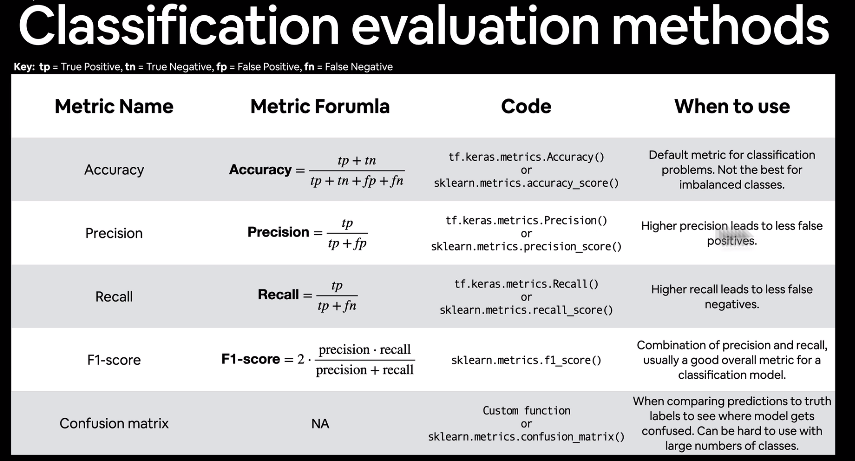

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": round(model_accuracy * 100,3),
                  "precision": round(model_precision * 100,3),
                  "recall": round(model_recall * 100,3),
                  "f1": round(model_f1 * 100,3)}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.265, 'f1': 78.622, 'precision': 81.114, 'recall': 79.265}

### Model 1: A simple dense model

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model 
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
#x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

Most of the trainable parameters are contained within the embedding layer. Recall we created an embedding of size 128 (`output_dim=128`) for a vocabulary of size 10,000 (`input_dim=10000`), hence the 1,280,000 trainable parameters.

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220523-145555
Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.6385 - accuracy: 0.6580 - val_loss: 0.5738 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4667 - accuracy: 0.8297 - val_loss: 0.4715 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3381 - accuracy: 0.8775 - val_loss: 0.4543 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2563 - accuracy: 0.9083 - val_loss: 0.4566 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.1966 - accuracy: 0.9349 - val_loss: 0.4698 - val_accuracy: 0.7966


In [ ]:
# accuracy for GlobalMaxPool1D
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4698 - accuracy: 0.7966


[0.46982529759407043, 0.7965879440307617]

In [ ]:
# check the results for GlobalAveragePooling1D
# model_1.evaluate(val_sentences, val_labels)

In [ ]:
# make some predicitons 
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [ ]:
model_1_pred_probs[0]

array([0.42973986], dtype=float32)

as it is a binary classification the threshold is going to be anything 

Below 0.5 --> class 0 (not disaster)

over 0.5 --> class 1 (disaster)

In [ ]:
# convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_1_pred_probs[:10]

array([[0.42973986],
       [0.8068699 ],
       [0.99469864],
       [0.06225214],
       [0.2934886 ],
       [0.9636168 ],
       [0.93441004],
       [0.9842577 ],
       [0.93567634],
       [0.1148156 ]], dtype=float32)

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.659, 'f1': 79.393, 'precision': 80.124, 'recall': 79.659}

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)


Baseline accuracy: 79.27, New accuracy: 79.66, Difference: 0.39
Baseline precision: 81.11, New precision: 80.12, Difference: -0.99
Baseline recall: 79.27, New recall: 79.66, Difference: 0.39
Baseline f1: 78.62, New f1: 79.39, Difference: 0.77


### Model 2: LSTM
Our model is going to take on a very similar structure to `model_1`:

Input (text) --> Tokenize --> Embedding --> Layers --> Output (label probability)


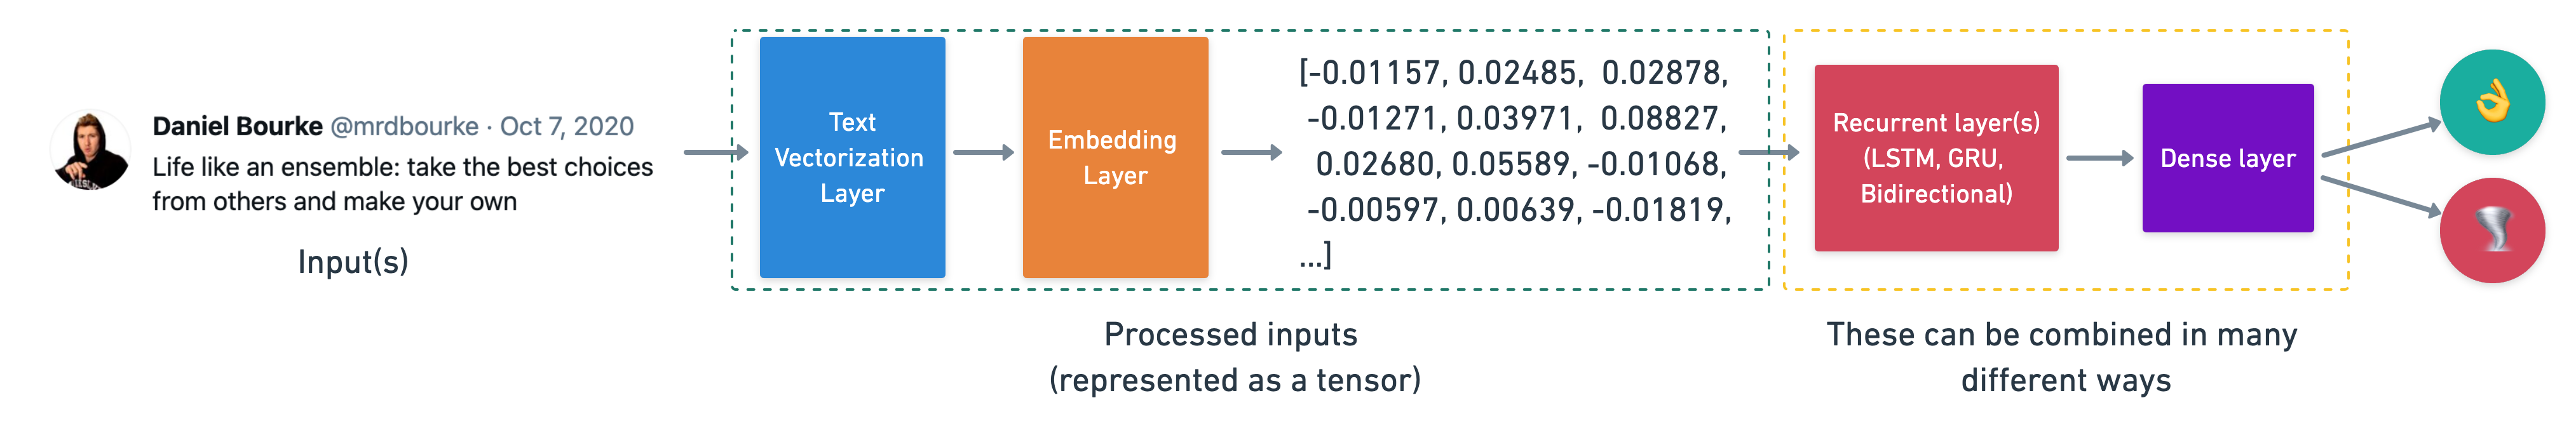

In [ ]:
# create LSTM model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
#print(x.shape)
x = layers.LSTM(64)(x)
#x = layers.Dense(128, activation='relu')(x)
#print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_lstm')

In [ ]:
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220523-145602
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.3705 - accuracy: 0.8368 - val_loss: 0.4558 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2466 - accuracy: 0.9050 - val_loss: 0.5581 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1746 - accuracy: 0.9361 - val_loss: 0.6062 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1316 - accuracy: 0.9534 - val_loss: 0.6664 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0980 - accuracy: 0.9626 - val_loss: 0.8095 - val_accuracy: 0.7638


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[0.02460229],
        [0.74636114],
        [0.99955374],
        [0.090248  ],
        [0.00783017],
        [0.99975806],
        [0.7038366 ],
        [0.9998135 ],
        [0.9997981 ],
        [0.512658  ]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.378, 'f1': 76.214, 'precision': 76.438, 'recall': 76.378}

In [ ]:
baseline_results

{'accuracy': 79.265, 'f1': 78.622, 'precision': 81.114, 'recall': 79.265}

###Model 3: GRU
The GRU cell has similar features to an LSTM cell but has less parameters.

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [ ]:
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

The difference comes from the `LSTM` cell having more trainable parameters than the `GRU` cell.

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220523-145615
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.2011 - accuracy: 0.9132 - val_loss: 0.6099 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1004 - accuracy: 0.9663 - val_loss: 0.7925 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0810 - accuracy: 0.9704 - val_loss: 0.9131 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0706 - accuracy: 0.9739 - val_loss: 0.9098 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0565 - accuracy: 0.9772 - val_loss: 0.9295 - val_accuracy: 0.7664


In [ ]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[1.7474771e-02],
        [8.1616038e-01],
        [9.9952674e-01],
        [1.8200354e-01],
        [8.6735055e-04],
        [9.9943477e-01],
        [7.2901911e-01],
        [9.9984741e-01],
        [9.9982822e-01],
        [8.7378383e-01]], dtype=float32))

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.64, 'f1': 76.587, 'precision': 76.602, 'recall': 76.64}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 81.11, New precision: 76.60, Difference: -4.51
Baseline recall: 79.27, New recall: 76.64, Difference: -2.62
Baseline f1: 78.62, New f1: 76.59, Difference: -2.03


### Model 4: Bidirectonal RNN model
A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.



In [ ]:
tf.random.set_seed(42)
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

Note: You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20220523-145755
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.0457 - accuracy: 0.9800 - val_loss: 1.2823 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0363 - accuracy: 0.9820 - val_loss: 1.2240 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0316 - accuracy: 0.9832 - val_loss: 1.6011 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0336 - accuracy: 0.9826 - val_loss: 1.1610 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0329 - accuracy: 0.9835 - val_loss: 1.5597 - val_accuracy: 0.7677


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.53389406],
       [0.5187648 ],
       [0.53017336],
       [0.5201485 ],
       [0.53748775],
       [0.5308428 ],
       [0.52476186],
       [0.52586395],
       [0.5264476 ],
       [0.52995044]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 45.801, 'f1': 29.378, 'precision': 53.472, 'recall': 45.801}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 45.80, Difference: -33.46
Baseline precision: 81.11, New precision: 53.47, Difference: -27.64
Baseline recall: 79.27, New recall: 45.80, Difference: -33.46
Baseline f1: 78.62, New f1: 29.38, Difference: -49.24
